# Pre-Equilibrium Maximazation of Yield #

In [1]:
# make sure jupyter path is correct for loading local moudules
import sys
# path to steric_simulator module relative to notebook
sys.path.append("../../../")
import copy

In [2]:
from steric_free_simulator import ReactionNetwork, VectorizedRxnNet, VecSim, Optimizer, EquilibriumSolver

EnergyExplorer Module is not available. Check Rosetta installation. <ipykernel.iostream.OutStream object at 0x7f74f4695080>


We'll start with the AP2 complex that we've worked with before. Pairwise $\Delta Gs$ were derived from the PDB structures via Rossetta

In [3]:
base_input = '../../input_files/trimer_one_species.pwr'
rn = ReactionNetwork(base_input, one_step=True)
rn.resolve_tree()


['default_assoc', 1.0]
['max_subunits', 3]
Using multiGraph
['A']
Parsing rule...
['A(a)+A(a)<->A(a!1).A(a!1)', 'G=-25']
['A', 'A', '']
['A(a)+A(a)', 'A(a!1).A(a!1)']
GGGGGGGGGgg
Node-1 :  (0, {'struct': <networkx.classes.multigraph.MultiGraph object at 0x7f74f0673b00>, 'copies': tensor([300.], dtype=torch.float64)})
Node-2 :  (0, {'struct': <networkx.classes.multigraph.MultiGraph object at 0x7f74f0673b00>, 'copies': tensor([300.], dtype=torch.float64)})
-----
{'A'}
{'A'}
set()
Steric hindrance detected
Adding another subunit
Allowed edges: 
('A', 'A')
############################3
[]
New node added--1
['A']
Adding an new edge-- 0 1
New bonds:  [('A', 'A')]
Adding an new edge-- 0 1
New node added--2
[0, 1]
Trying internal bonds
Allowed edges: 
('A', 'A')
############################3
[(1, {'struct': <networkx.classes.multigraph.MultiGraph object at 0x7f745e47dcc0>, 'copies': tensor([0.], dtype=torch.float64)})]
Node-1 :  (1, {'struct': <networkx.classes.multigraph.MultiGraph object at 

In [4]:
uid_dict = {}
sys.path.append("../../")
import numpy as np
from reaction_network import gtostr
for n in rn.network.nodes():
    print(n)
    print(gtostr(rn.network.nodes()[n]['struct']))
    for k,v in rn.network[n].items():
        print(v)
        uid = v['uid']
        r1 = set(gtostr(rn.network.nodes[n]['struct']))
        p = set(gtostr(rn.network.nodes[k]['struct']))
        r2 = p-r1
        reactants = (r1,r2)
        uid_dict[(n,k)] = uid

print(uid_dict)


0
A
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-25.], dtype=torch.float64), 'uid': 0}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-50.], dtype=torch.float64), 'uid': 1}
1
A
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-50.], dtype=torch.float64), 'uid': 1}
2
A
{(0, 1): 0, (0, 2): 1, (1, 2): 1}


A -- 0
[]
AA -- 1
[('A', 'A')]
AAAA -- 2
[('A', 'A'), ('A', 'A'), ('A', 'A')]
{2: {'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-50.], dtype=torch.float64), 'uid': 1}}


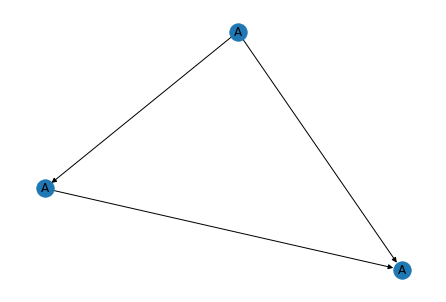

In [5]:
import networkx as nx
labels = nx.get_node_attributes(rn.network, 'struct')
labels = {key:gtostr(labels[key]) for key in labels.keys()}
nx.draw(rn.network, labels=labels)

for node in rn.network.nodes(data=True):
    st = gtostr(node[1]['struct'])
    n_edges = node[1]['struct'].number_of_edges()
#     st1 = [set(i) for i in node[1]['struct'].edges()]
#     a=[]
#     for i in st1:
#         a+=list(i) 
    
    if n_edges >= len(set(st)):
        st= st+n_edges*st
    print(st,"--",node[0])
#     print("".join(a), "--",node[0])
    print(node[1]['struct'].edges())
    
print(rn.network[1]) 

In [6]:
# def _equal(n1, n2) -> bool:
#     """
#     Test whether two structures have identical connectivity
#     :param n1: nx.Graph
#     :param n2: nx.Graph
#     :return: Boolean indicating whether or not graphs are equal
#     """
#     nm = nx.algorithms.isomorphism.categorical_node_match("label", None)
#     int_n1 = nx.convert_node_labels_to_integers(n1, label_attribute="label")
#     int_n2 = nx.convert_node_labels_to_integers(n2, label_attribute="label")
#     print(int_n1)
#     print(int_n2)
#     return nx.is_isomorphic(int_n1, int_n2, node_match=nm)

# repeat_units=False
# import networkx as nx
# for i in range(len(rn.network.nodes)):
#     for (u,v) in rn.network.nodes[i]['struct'].edges:
#         if u==v:
#             repeat_units=True
#             print(repeat_units)
#         print(u,v)
#     print(i)

# # orig = rn.network.nodes[0]['struct']
# # orig = nx.relabel_nodes(orig,{'A':'AA'})
# # orig.add_edge('A','AA')
# # print(orig.nodes.data)

# # print(orig.nodes)

# # node_exists = [x for x in rn.network.nodes(data=True) if
# #                        _equal(x[1]['struct'], orig)]

# # print(node_exists)

In [7]:
#Changing Initial Conditions
import networkx as nx
#Changin k_on
new_kon = [1.0,1.0,1.0,1.0]*np.array([1e0])  #Poor yield Simruntime = 1sec

update_kon_dict = {}
for edge in rn.network.edges:
    print(rn.network.get_edge_data(edge[0],edge[1]))
    update_kon_dict[edge] = new_kon[uid_dict[edge]]

nx.set_edge_attributes(rn.network,update_kon_dict,'k_on')

for edge in rn.network.edges:
    print(rn.network.get_edge_data(edge[0],edge[1]))
vec_rn = VectorizedRxnNet(rn, dev='cpu')
print(vec_rn.kon)

{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-25.], dtype=torch.float64), 'uid': 0}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-50.], dtype=torch.float64), 'uid': 1}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-50.], dtype=torch.float64), 'uid': 1}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-25.], dtype=torch.float64), 'uid': 0}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-50.], dtype=torch.float64), 'uid': 1}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-50.], dtype=torch.float64), 'uid': 1}
A
Reactant Sets:
A
Reactant Sets:
(0,)
A
Reactant Sets:
(0, 1)
tensor([[-2., -1.,  2.,  1.],
        [ 1., -1., -1.,  1.],
        [ 0.,  1., -0., -1.]], dtype=torch.float64)
tensor([1., 1.], dtype=torch.float64, grad_fn=<CopySlices>)
Parameter containing:
tensor([1., 1.], dtype=torch.float64, requires_grad=True)


## The Equilibrium Solution ##
First we will find the equilibrium solution for this system.

In [8]:
# vec_rn.update_reaction_net(rn,1)
# poly_system = EquilibriumSolver(rn)
# solution = poly_system.solve()
# if solution == None:
#     print("No Equilibrium solution")
# else:
#     print(solution)
#     print("Equilibrium expected yield: ", 100 * solution[-1] / min(vec_rn.initial_copies[:vec_rn.num_monomers]), '%')
# print(vec_rn.kon)

In [9]:
# uid_dict = {}
# sys.path.append("../")
# import numpy as np
# from reaction_network import gtostr
# for n in rn.network.nodes():
#     #print(n)
#     #print(rn.network.nodes()[n])
#     for k,v in rn.network[n].items():
#         uid = v['uid']
#         r1 = set(gtostr(rn.network.nodes[n]['struct']))
#         p = set(gtostr(rn.network.nodes[k]['struct']))
#         r2 = p-r1
#         reactants = (r1,r2)
#         uid_val = {'reactants':reactants,'kon':v['k_on'],'score':v['rxn_score'],'koff':v['k_off'],'uid':uid}
#         if uid not in uid_dict.keys():
#             uid_dict[uid] = uid_val
#     print(gtostr(rn.network.nodes[n]['struct']))
#     #for r_set in rn.get_reactant_sets(n):
#     #    print(tuple(r_set))
#     #print(rn.network[n]['struct'])
# ind_sort = np.argsort(vec_rn.kon.detach().numpy())
# for i in ind_sort:
#     print(vec_rn.kon[i])
#     print(uid_dict[i])

In [10]:
# uid_dict = {}
# sys.path.append("../")
# import numpy as np
# from reaction_network import gtostr
# from torch import DoubleTensor as Tensor
# import torch

# node_map = {}
# for node in rn.network.nodes():
#     node_map[gtostr(rn.network.nodes[node]['struct'])] = node

# print(node_map)

# def get_max_edge(n):
#     """
#     Calculates the max rate (k_on) for a given node
#     To find out the maximum flow path to the final complex starting from the current node.
    
#     Can also calculate the total rate of consumption of a node by summing up all rates. 
#     Can tell which component is used quickly.
#     """
#     try:
#         edges = rn.network.out_edges(n)
#         #Loop over all edges
#         #Get attributes
#         if len(edges)==0:
#             return(False)
#         kon_max = -1
#         next_node = -1
        
#         kon_sum = 0
#         for edge in edges:
#             data = rn.network.get_edge_data(edge[0],edge[1])
#             #print(data)
#             #Get uid
#             uid = data['uid']
#             #Get updated kon
#             temp_kon = vec_rn.kon[uid]
#             kon_sum+=temp_kon
            
#             if temp_kon > kon_max:
#                 kon_max = temp_kon
#                 next_node=edge[1]
#         return(kon_max,next_node,kon_sum)
#     except Exception as err:
#         raise(err)
# def get_node_flux(n):
#     total_flux_outedges = 0
#     total_flux_inedges = 0
#     #Go over all the out edges
#     edges_out = rn.network.out_edges(n)
#     if len(edges_out)>0:

#         for edge in edges_out:
#             data = rn.network.get_edge_data(edge[0],edge[1])
#             #print(data)
#             #Get uid
#             uid = data['uid']

#             #Get updated kon
#             temp_kon = vec_rn.kon[uid]

#             #Calculate k_off also
#             std_c = Tensor([1.])
#             l_kon = torch.log(temp_kon)
#             l_koff = (vec_rn.rxn_score_vec[uid] * 1. / (vec_rn._R * vec_rn._T)) + l_kon + torch.log(std_c)
#             koff = torch.exp(l_koff)

#             #Getting conc. of reactants and products
#             #Get product
#             prod = gtostr(rn.network.nodes[edge[1]]['struct']) 
#             #Get other reactant
#             react = "".join(sorted(list(set(prod) - set(gtostr(rn.network.nodes[edge[0]]['struct']) ))))

#             #Net flux from this edge = Generation - consumption
#             edge_flux = koff*solution[edge[1]] - temp_kon*(solution[edge[0]])*(solution[node_map[react]])
#             #edge_flux = koff*vec_rn.copies_vec[edge[1]] 

#             print("Reaction: ", gtostr(rn.network.nodes[edge[0]]['struct']), "+",react," -> ",prod)
#             print("Net flux: ",edge_flux)
#             print("kon : ",temp_kon)
#             print("koff: ",koff)
#             print("Free Energy: ",vec_rn.rxn_score_vec[uid])
#             print("Reaction data OUTWARD: ")
#             print(data)

#             total_flux_outedges+=edge_flux
    
#     #Now go over all the in edges
#     edges_in = rn.network.in_edges(n)
#     react_list = []
#     if len(edges_in) > 0:
#         for edge in edges_in:
#             if edge[0] in react_list:
#                 continue
#             data = rn.network.get_edge_data(edge[0],edge[1])
#             uid = data['uid']


#             #Get generation rates; which would be kon
#             temp_kon = vec_rn.kon[uid]

#             #Get consumption rates; which is k_off
#             std_c = Tensor([1.])
#             l_kon = torch.log(temp_kon)
#             l_koff = (vec_rn.rxn_score_vec[uid] * 1. / (vec_rn._R * vec_rn._T)) + l_kon + torch.log(std_c)
#             koff = torch.exp(l_koff)

#             #Get conc. of reactants and products
#             prod = gtostr(rn.network.nodes[edge[1]]['struct'])
#             #Get other reactant
#             react = "".join(sorted(list(set(prod) - set(gtostr(rn.network.nodes[edge[0]]['struct']) ))))
#             react_list.append(node_map[react])
#             #Net flux from this edge = Generation - consumption
#             edge_flux_in = temp_kon*(solution[edge[0]])*(solution[node_map[react]])- koff*solution[edge[1]]
#             #edge_flux_in = koff*vec_rn.copies_vec[edge[1]]
            


#             print("Reaction: ", prod ," -> ",gtostr(rn.network.nodes[edge[0]]['struct']), "+",react)
#             print("Net flux: ",edge_flux_in)
#             print("kon : ",temp_kon)
#             print("koff: ",koff)
#             print("Raction data INWARD: ")
#             print(data)

#             total_flux_inedges+=edge_flux_in
#     net_node_flux = total_flux_outedges + total_flux_inedges
    
#     return(net_node_flux)
# pathway = []
# kon_sumarray = []
# total_con_rate = {}
# net_flux = {}

# if solution != None:
#     for n in rn.network.nodes():

#         n_str = gtostr(rn.network.nodes[n]['struct']) 

#         paths = [n_str]
#         kon_sum = 0
#         temp_node = n
#         max_edge = True
#         consumption_rate = 0
#         if n < len(rn.network.nodes()):#num_monomers:
#     #         print("Current node: ")
#     #         print(n_str)
#             while max_edge:
#                 max_edge = get_max_edge(temp_node)
#                 if max_edge:
#                     total_con_rate[gtostr(rn.network.nodes[temp_node]['struct'])] = max_edge[2]
#                     temp_node = max_edge[1]
#                     kon_sum += max_edge[0].item()


#     #                 print("Next node: ")
#     #                 print(temp_node)

#                     paths.append(gtostr(rn.network.nodes[temp_node]['struct']))
#                 else:
#                     break
#             pathway.append(paths)
#             kon_sumarray.append(kon_sum)
#             paths=[]

#         print("-------------------------------------------------------------------------------")
#         print("-------------------------------------------------------------------------------")
#         print("|                                                                             |")
#         node_flux = get_node_flux(n)
#         net_flux[gtostr(rn.network.nodes[n]['struct'])] = node_flux
#         print("|                                                                             |")
#         print("-------------------------------------------------------------------------------")
#         print("-------------------------------------------------------------------------------")

#     print(pathway)
#     print(kon_sumarray)
#     #print(total_con_rate)

In [11]:
# if solution != None:
#     for k,v in sorted(total_con_rate.items(),key=lambda x : x[1]):
#         print(k," : ", v.item())

In [12]:
# if solution !=None:
#     for k,v in sorted(net_flux.items(),key=lambda x : x[1]):
#         print(k," : ", v)



## Using the optimizer with a 1 second simulation runtime ##

In [ ]:
vec_rn.reset(reset_params=True)
optim = Optimizer(reaction_network=vec_rn,
                  sim_runtime=1,
                  optim_iterations=5000,
                  learning_rate=new_kon[0]/1e3,
                  device='cpu',method="RMSprop")
optim.rn.update_reaction_net(rn)
optim.optimize()

Using CPU
Reaction Parameters before optimization: 
[Parameter containing:
tensor([1., 1.], dtype=torch.float64, requires_grad=True)]
Using CPU
yield on sim iteration 0 was 32.8%
current params: tensor([0.9900, 1.0100], dtype=torch.float64)
Using CPU
yield on sim iteration 1 was 32.8%
current params: tensor([0.9829, 1.0170], dtype=torch.float64)
Using CPU
yield on sim iteration 2 was 32.9%
current params: tensor([0.9772, 1.0226], dtype=torch.float64)
Using CPU
yield on sim iteration 3 was 32.9%
current params: tensor([0.9722, 1.0275], dtype=torch.float64)
Using CPU
yield on sim iteration 4 was 32.9%
current params: tensor([0.9677, 1.0319], dtype=torch.float64)
Using CPU
yield on sim iteration 5 was 32.9%
current params: tensor([0.9637, 1.0358], dtype=torch.float64)
Using CPU
yield on sim iteration 6 was 32.9%
current params: tensor([0.9599, 1.0395], dtype=torch.float64)
Using CPU
yield on sim iteration 7 was 32.9%
current params: tensor([0.9564, 1.0429], dtype=torch.float64)
Using CPU


yield on sim iteration 75 was 32.9%
current params: tensor([0.8430, 1.1485], dtype=torch.float64)
Using CPU
yield on sim iteration 76 was 32.9%
current params: tensor([0.8419, 1.1495], dtype=torch.float64)
Using CPU
yield on sim iteration 77 was 32.9%
current params: tensor([0.8407, 1.1505], dtype=torch.float64)
Using CPU
yield on sim iteration 78 was 32.9%
current params: tensor([0.8396, 1.1515], dtype=torch.float64)
Using CPU
yield on sim iteration 79 was 32.9%
current params: tensor([0.8385, 1.1524], dtype=torch.float64)
Using CPU
yield on sim iteration 80 was 32.9%
current params: tensor([0.8374, 1.1534], dtype=torch.float64)
Using CPU
yield on sim iteration 81 was 32.9%
current params: tensor([0.8363, 1.1544], dtype=torch.float64)
Using CPU
yield on sim iteration 82 was 32.9%
current params: tensor([0.8353, 1.1554], dtype=torch.float64)
Using CPU
yield on sim iteration 83 was 32.9%
current params: tensor([0.8342, 1.1564], dtype=torch.float64)
Using CPU
yield on sim iteration 84 wa

yield on sim iteration 151 was 32.9%
current params: tensor([0.7633, 1.2178], dtype=torch.float64)
Using CPU
yield on sim iteration 152 was 32.9%
current params: tensor([0.7623, 1.2187], dtype=torch.float64)
Using CPU
yield on sim iteration 153 was 32.9%
current params: tensor([0.7613, 1.2195], dtype=torch.float64)
Using CPU
yield on sim iteration 154 was 32.9%
current params: tensor([0.7603, 1.2204], dtype=torch.float64)
Using CPU
yield on sim iteration 155 was 32.9%
current params: tensor([0.7593, 1.2212], dtype=torch.float64)
Using CPU
yield on sim iteration 156 was 32.7%
current params: tensor([0.7583, 1.2221], dtype=torch.float64)
Using CPU
yield on sim iteration 157 was 32.7%
current params: tensor([0.7573, 1.2229], dtype=torch.float64)
Using CPU
yield on sim iteration 158 was 32.7%
current params: tensor([0.7563, 1.2238], dtype=torch.float64)
Using CPU
yield on sim iteration 159 was 32.7%
current params: tensor([0.7553, 1.2246], dtype=torch.float64)
Using CPU
yield on sim iterat

current params: tensor([0.6897, 1.2792], dtype=torch.float64)
Using CPU
yield on sim iteration 227 was 32.6%
current params: tensor([0.6887, 1.2800], dtype=torch.float64)
Using CPU
yield on sim iteration 228 was 32.6%
current params: tensor([0.6877, 1.2808], dtype=torch.float64)
Using CPU
yield on sim iteration 229 was 32.6%
current params: tensor([0.6868, 1.2816], dtype=torch.float64)
Using CPU
yield on sim iteration 230 was 32.6%
current params: tensor([0.6858, 1.2824], dtype=torch.float64)
Using CPU
yield on sim iteration 231 was 32.6%
current params: tensor([0.6848, 1.2832], dtype=torch.float64)
Using CPU
yield on sim iteration 232 was 32.6%
current params: tensor([0.6839, 1.2840], dtype=torch.float64)
Using CPU
yield on sim iteration 233 was 32.6%
current params: tensor([0.6829, 1.2847], dtype=torch.float64)
Using CPU
yield on sim iteration 234 was 32.6%
current params: tensor([0.6819, 1.2855], dtype=torch.float64)
Using CPU
yield on sim iteration 235 was 32.6%
current params: ten

yield on sim iteration 302 was 32.5%
current params: tensor([0.6169, 1.3379], dtype=torch.float64)
Using CPU
yield on sim iteration 303 was 32.5%
current params: tensor([0.6159, 1.3386], dtype=torch.float64)
Using CPU
yield on sim iteration 304 was 32.5%
current params: tensor([0.6150, 1.3394], dtype=torch.float64)
Using CPU
yield on sim iteration 305 was 32.5%
current params: tensor([0.6140, 1.3402], dtype=torch.float64)
Using CPU
yield on sim iteration 306 was 32.5%
current params: tensor([0.6131, 1.3409], dtype=torch.float64)
Using CPU
yield on sim iteration 307 was 32.5%
current params: tensor([0.6121, 1.3417], dtype=torch.float64)
Using CPU
yield on sim iteration 308 was 32.5%
current params: tensor([0.6112, 1.3424], dtype=torch.float64)
Using CPU
yield on sim iteration 309 was 32.5%
current params: tensor([0.6102, 1.3432], dtype=torch.float64)
Using CPU
yield on sim iteration 310 was 32.5%
current params: tensor([0.6093, 1.3439], dtype=torch.float64)
Using CPU
yield on sim iterat

current params: tensor([0.5457, 1.3936], dtype=torch.float64)
Using CPU
yield on sim iteration 378 was 32.0%
current params: tensor([0.5448, 1.3943], dtype=torch.float64)
Using CPU
yield on sim iteration 379 was 32.0%
current params: tensor([0.5438, 1.3950], dtype=torch.float64)
Using CPU
yield on sim iteration 380 was 32.0%
current params: tensor([0.5429, 1.3957], dtype=torch.float64)
Using CPU
yield on sim iteration 381 was 32.0%
current params: tensor([0.5419, 1.3965], dtype=torch.float64)
Using CPU
yield on sim iteration 382 was 32.0%
current params: tensor([0.5410, 1.3972], dtype=torch.float64)
Using CPU
yield on sim iteration 383 was 32.0%
current params: tensor([0.5401, 1.3979], dtype=torch.float64)
Using CPU
yield on sim iteration 384 was 32.0%
current params: tensor([0.5391, 1.3987], dtype=torch.float64)
Using CPU
yield on sim iteration 385 was 32.0%
current params: tensor([0.5382, 1.3994], dtype=torch.float64)
Using CPU
yield on sim iteration 386 was 32.0%
current params: ten

current params: tensor([0.4738, 1.4481], dtype=torch.float64)
Using CPU
yield on sim iteration 454 was 31.3%
current params: tensor([0.4729, 1.4489], dtype=torch.float64)
Using CPU
yield on sim iteration 455 was 31.3%
current params: tensor([0.4719, 1.4496], dtype=torch.float64)
Using CPU
yield on sim iteration 456 was 31.3%
current params: tensor([0.4710, 1.4503], dtype=torch.float64)
Using CPU
yield on sim iteration 457 was 31.3%
current params: tensor([0.4701, 1.4510], dtype=torch.float64)
Using CPU
yield on sim iteration 458 was 31.3%
current params: tensor([0.4691, 1.4517], dtype=torch.float64)
Using CPU
yield on sim iteration 459 was 31.3%
current params: tensor([0.4682, 1.4524], dtype=torch.float64)
Using CPU
yield on sim iteration 460 was 31.3%
current params: tensor([0.4672, 1.4531], dtype=torch.float64)
Using CPU
yield on sim iteration 461 was 31.3%
current params: tensor([0.4663, 1.4538], dtype=torch.float64)
Using CPU
yield on sim iteration 462 was 31.3%
current params: ten

current params: tensor([0.4019, 1.5009], dtype=torch.float64)
Using CPU
yield on sim iteration 530 was 30.4%
current params: tensor([0.4009, 1.5016], dtype=torch.float64)
Using CPU
yield on sim iteration 531 was 30.4%
current params: tensor([0.4000, 1.5022], dtype=torch.float64)
Using CPU
yield on sim iteration 532 was 30.4%
current params: tensor([0.3990, 1.5029], dtype=torch.float64)
Using CPU
yield on sim iteration 533 was 30.4%
current params: tensor([0.3981, 1.5036], dtype=torch.float64)
Using CPU
yield on sim iteration 534 was 30.2%
current params: tensor([0.3972, 1.5043], dtype=torch.float64)
Using CPU
yield on sim iteration 535 was 30.2%
current params: tensor([0.3962, 1.5050], dtype=torch.float64)
Using CPU
yield on sim iteration 536 was 30.2%
current params: tensor([0.3953, 1.5056], dtype=torch.float64)
Using CPU
yield on sim iteration 537 was 30.2%
current params: tensor([0.3943, 1.5063], dtype=torch.float64)
Using CPU
yield on sim iteration 538 was 30.2%
current params: ten

Using CPU
yield on sim iteration 606 was 28.7%
current params: tensor([0.3288, 1.5521], dtype=torch.float64)
Using CPU
yield on sim iteration 607 was 28.7%
current params: tensor([0.3279, 1.5527], dtype=torch.float64)
Using CPU
yield on sim iteration 608 was 28.7%
current params: tensor([0.3269, 1.5533], dtype=torch.float64)
Using CPU
yield on sim iteration 609 was 28.7%
current params: tensor([0.3260, 1.5540], dtype=torch.float64)
Using CPU
yield on sim iteration 610 was 28.5%
current params: tensor([0.3250, 1.5546], dtype=torch.float64)
Using CPU
yield on sim iteration 611 was 28.5%
current params: tensor([0.3241, 1.5553], dtype=torch.float64)
Using CPU
yield on sim iteration 612 was 28.5%
current params: tensor([0.3231, 1.5559], dtype=torch.float64)
Using CPU
yield on sim iteration 613 was 28.5%
current params: tensor([0.3222, 1.5566], dtype=torch.float64)
Using CPU
yield on sim iteration 614 was 28.5%
current params: tensor([0.3212, 1.5572], dtype=torch.float64)
Using CPU
yield on 

current params: tensor([0.2574, 1.5989], dtype=torch.float64)
Using CPU
yield on sim iteration 682 was 26.2%
current params: tensor([0.2565, 1.5995], dtype=torch.float64)
Using CPU
yield on sim iteration 683 was 26.2%
current params: tensor([0.2555, 1.6001], dtype=torch.float64)
Using CPU
yield on sim iteration 684 was 26.2%
current params: tensor([0.2546, 1.6007], dtype=torch.float64)
Using CPU
yield on sim iteration 685 was 26.1%
current params: tensor([0.2536, 1.6013], dtype=torch.float64)
Using CPU
yield on sim iteration 686 was 26.1%
current params: tensor([0.2527, 1.6019], dtype=torch.float64)
Using CPU
yield on sim iteration 687 was 26.1%
current params: tensor([0.2517, 1.6025], dtype=torch.float64)
Using CPU
yield on sim iteration 688 was 26.1%
current params: tensor([0.2508, 1.6031], dtype=torch.float64)
Using CPU
yield on sim iteration 689 was 25.9%
current params: tensor([0.2498, 1.6037], dtype=torch.float64)
Using CPU
yield on sim iteration 690 was 25.9%
current params: ten

yield on sim iteration 758 was 23.9%
current params: tensor([0.2087, 1.6288], dtype=torch.float64)
Using CPU
yield on sim iteration 759 was 23.9%
current params: tensor([0.2082, 1.6293], dtype=torch.float64)
Using CPU
yield on sim iteration 760 was 23.7%
current params: tensor([0.2075, 1.6298], dtype=torch.float64)
Using CPU
yield on sim iteration 761 was 23.7%
current params: tensor([0.2068, 1.6304], dtype=torch.float64)
Using CPU
yield on sim iteration 762 was 23.7%
current params: tensor([0.2058, 1.6312], dtype=torch.float64)
Using CPU
yield on sim iteration 763 was 23.7%
current params: tensor([0.2034, 1.6331], dtype=torch.float64)
Using CPU
yield on sim iteration 764 was 23.6%
current params: tensor([0.2096, 1.6279], dtype=torch.float64)
Using CPU
yield on sim iteration 765 was 23.9%
current params: tensor([0.2092, 1.6283], dtype=torch.float64)
Using CPU
yield on sim iteration 766 was 23.9%
current params: tensor([0.2088, 1.6287], dtype=torch.float64)
Using CPU
yield on sim iterat

current params: tensor([0.2047, 1.6341], dtype=torch.float64)
Using CPU
yield on sim iteration 835 was 23.6%
current params: tensor([0.2079, 1.6312], dtype=torch.float64)
Using CPU
yield on sim iteration 836 was 23.7%
current params: tensor([0.2075, 1.6316], dtype=torch.float64)
Using CPU
yield on sim iteration 837 was 23.7%
current params: tensor([0.2070, 1.6320], dtype=torch.float64)
Using CPU
yield on sim iteration 838 was 23.7%
current params: tensor([0.2065, 1.6326], dtype=torch.float64)
Using CPU
yield on sim iteration 839 was 23.7%
current params: tensor([0.2056, 1.6334], dtype=torch.float64)
Using CPU
yield on sim iteration 840 was 23.6%
current params: tensor([0.2069, 1.6322], dtype=torch.float64)
Using CPU
yield on sim iteration 841 was 23.7%
current params: tensor([0.2063, 1.6328], dtype=torch.float64)
Using CPU
yield on sim iteration 842 was 23.7%
current params: tensor([0.2053, 1.6338], dtype=torch.float64)
Using CPU
yield on sim iteration 843 was 23.6%
current params: ten

yield on sim iteration 911 was 23.6%
current params: tensor([0.2069, 1.6338], dtype=torch.float64)
Using CPU
yield on sim iteration 912 was 23.7%
current params: tensor([0.2064, 1.6343], dtype=torch.float64)
Using CPU
yield on sim iteration 913 was 23.7%
current params: tensor([0.2056, 1.6351], dtype=torch.float64)
Using CPU
yield on sim iteration 914 was 23.6%
current params: tensor([0.2069, 1.6339], dtype=torch.float64)
Using CPU
yield on sim iteration 915 was 23.7%
current params: tensor([0.2063, 1.6344], dtype=torch.float64)
Using CPU
yield on sim iteration 916 was 23.7%
current params: tensor([0.2055, 1.6353], dtype=torch.float64)
Using CPU
yield on sim iteration 917 was 23.6%
current params: tensor([0.2070, 1.6339], dtype=torch.float64)
Using CPU
yield on sim iteration 918 was 23.7%
current params: tensor([0.2064, 1.6344], dtype=torch.float64)
Using CPU
yield on sim iteration 919 was 23.7%
current params: tensor([0.2057, 1.6352], dtype=torch.float64)
Using CPU
yield on sim iterat

In [ ]:
print(optim.yield_per_iter[-1])

In [ ]:
uid_dict = {}
sys.path.append("../")
import numpy as np
from reaction_network import gtostr
for n in rn.network.nodes():
    #print(n)
    #print(rn.network.nodes()[n])
    for k,v in rn.network[n].items():
        uid = v['uid']
        r1 = set(gtostr(rn.network.nodes[n]['struct']))
        p = set(gtostr(rn.network.nodes[k]['struct']))
        r2 = p-r1
        reactants = (r1,r2)
        uid_val = {'reactants':reactants,'kon':v['k_on'],'score':v['rxn_score'],'koff':v['k_off'],'uid':uid}
        if uid not in uid_dict.keys():
            uid_dict[uid] = uid_val
    print(gtostr(rn.network.nodes[n]['struct']))
    #for r_set in rn.get_reactant_sets(n):
    #    print(tuple(r_set))
    #print(rn.network[n]['struct'])
ind_sort = np.argsort(vec_rn.kon.detach().numpy())
for i in ind_sort:
    print(vec_rn.kon[i])
    print(uid_dict[i])

In [ ]:
# uid_dict = {}
# sys.path.append("../")
# import numpy as np
# from reaction_network import gtostr
# from torch import DoubleTensor as Tensor
# import torch

# node_map = {}
# for node in rn.network.nodes():
#     node_map[gtostr(rn.network.nodes[node]['struct'])] = node

# print(node_map)

# def get_max_edge(n):
#     """
#     Calculates the max rate (k_on) for a given node
#     To find out the maximum flow path to the final complex starting from the current node.
    
#     Can also calculate the total rate of consumption of a node by summing up all rates. 
#     Can tell which component is used quickly.
#     """
#     try:
#         edges = rn.network.out_edges(n)
#         #Loop over all edges
#         #Get attributes
#         kon_max = -1
#         next_node = -1

#         kon_sum = 0
#         total_flux_outedges = 0
#         total_flux_inedges = 0
#         if len(edges)==0:
#             return(False)
            
#         for edge in edges:
#             data = rn.network.get_edge_data(edge[0],edge[1])
#             #print(data)
#             #Get uid
#             uid = data['uid']

#             #Get updated kon
#             temp_kon = vec_rn.kon[uid]
#             kon_sum+=temp_kon
            
#             if temp_kon > kon_max:
#                 kon_max = temp_kon
#                 next_node=edge[1]
             
#         return(kon_max,next_node,kon_sum)
#     except Exception as err:
#         raise(err)

        
# def get_node_flux(n):
#     total_flux_outedges = 0
#     total_flux_inedges = 0
#     #Go over all the out edges
#     edges_out = rn.network.out_edges(n)
#     if len(edges_out)>0:

#         for edge in edges_out:
#             data = rn.network.get_edge_data(edge[0],edge[1])
#             #print(data)
#             #Get uid
#             uid = data['uid']

#             #Get updated kon
#             temp_kon = vec_rn.kon[uid]

#             #Calculate k_off also
#             std_c = Tensor([1.])
#             l_kon = torch.log(temp_kon)
#             l_koff = (vec_rn.rxn_score_vec[uid] * 1. / (vec_rn._R * vec_rn._T)) + l_kon + torch.log(std_c)
#             koff = torch.exp(l_koff)

#             #Getting conc. of reactants and products
#             #Get product
#             prod = gtostr(rn.network.nodes[edge[1]]['struct']) 
#             #Get other reactant
#             react = "".join(sorted(list(set(prod) - set(gtostr(rn.network.nodes[edge[0]]['struct']) ))))

#             #Net flux from this edge = Generation - consumption
#             edge_flux = koff*vec_rn.copies_vec[edge[1]] - temp_kon*(vec_rn.copies_vec[edge[0]])*(vec_rn.copies_vec[node_map[react]])
#             #edge_flux = koff*vec_rn.copies_vec[edge[1]] 

#             print("Reaction: ", gtostr(rn.network.nodes[edge[0]]['struct']), "+",react," -> ",prod)
#             print("Net flux: ",edge_flux)
#             print("kon : ",temp_kon)
#             print("koff: ",koff)
#             print("Reaction data OUTWARD: ")
#             print(data)

#             total_flux_outedges+=edge_flux
    
#     #Now go over all the in edges
#     edges_in = rn.network.in_edges(n)
#     react_list = []
#     if len(edges_in) > 0:
#         for edge in edges_in:
#             if edge[0] in react_list:
#                 continue
#             data = rn.network.get_edge_data(edge[0],edge[1])
#             uid = data['uid']


#             #Get generation rates; which would be kon
#             temp_kon = vec_rn.kon[uid]

#             #Get consumption rates; which is k_off
#             std_c = Tensor([1.])
#             l_kon = torch.log(temp_kon)
#             l_koff = (vec_rn.rxn_score_vec[uid] * 1. / (vec_rn._R * vec_rn._T)) + l_kon + torch.log(std_c)
#             koff = torch.exp(l_koff)

#             #Get conc. of reactants and products
#             prod = gtostr(rn.network.nodes[edge[1]]['struct'])
#             #Get other reactant
#             react = "".join(sorted(list(set(prod) - set(gtostr(rn.network.nodes[edge[0]]['struct']) ))))
#             react_list.append(node_map[react])
#             #Net flux from this edge = Generation - consumption
#             edge_flux_in = temp_kon*(vec_rn.copies_vec[edge[0]])*(vec_rn.copies_vec[node_map[react]])- koff*vec_rn.copies_vec[edge[1]]
#             #edge_flux_in = koff*vec_rn.copies_vec[edge[1]]
            


#             print("Reaction: ", prod ," -> ",gtostr(rn.network.nodes[edge[0]]['struct']), "+",react)
#             print("Net flux: ",edge_flux_in)
#             print("kon : ",temp_kon)
#             print("koff: ",koff)
#             print("Raction data INWARD: ")
#             print(data)

#             total_flux_inedges+=edge_flux_in
#     net_node_flux = total_flux_outedges + total_flux_inedges
    
#     return(net_node_flux)
    
# pathway = []
# kon_sumarray = []
# total_con_rate = {}
# net_flux = {}
# for n in rn.network.nodes():
    
#     n_str = gtostr(rn.network.nodes[n]['struct']) 
    
#     paths = [n_str]
#     kon_sum = 0
#     temp_node = n
#     max_edge = True
#     consumption_rate = 0
#     if n < len(rn.network.nodes()):#num_monomers:
# #         print("Current node: ")
# #         print(n_str)
#         while max_edge:
#             max_edge = get_max_edge(temp_node)
#             if max_edge:
#                 total_con_rate[gtostr(rn.network.nodes[temp_node]['struct'])] = max_edge[2]
                
#                 temp_node = max_edge[1]
#                 kon_sum += max_edge[0].item()
                
                
# #                 print("Next node: ")
# #                 print(temp_node)

#                 paths.append(gtostr(rn.network.nodes[temp_node]['struct']))
#             else:
#                 break
#         pathway.append(paths)
#         kon_sumarray.append(kon_sum)
#         paths=[]
#     print("-------------------------------------------------------------------------------")
#     print("-------------------------------------------------------------------------------")
#     print("|                                                                             |")
#     node_flux = get_node_flux(n)
#     net_flux[gtostr(rn.network.nodes[n]['struct'])] = node_flux
#     print("|                                                                             |")
#     print("-------------------------------------------------------------------------------")
#     print("-------------------------------------------------------------------------------")

# print(pathway)
# print(kon_sumarray)

# #print(total_con_rate)

In [ ]:
# for k,v in sorted(total_con_rate.items(),key=lambda x : x[1]):
#     print(k," : ", v.item())

In [ ]:
# for k,v in sorted(net_flux.items(),key=lambda x : x[1]):
#     print(k," : ", v)

# print(vec_rn.copies_vec)

In [ ]:
# for n in rn.network.nodes():
#     print(gtostr(rn.network.nodes[n]['struct']), " : ", n)

Let's first visualize some of the data.

**Without any optimization**


In [ ]:
nodes_list = ['A','B','AB']
#nodes_list = ['AB','BMS','ABS','AMS','ABMS','AM','BM','MS']
optim.plot_observable(0,nodes_list)



**After 750 optimization iterations**


In [ ]:

optim.plot_observable(-1,nodes_list)


In [ ]:
optim.plot_yield()

In [ ]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
ax.plot(optim.yield_per_iter)

It seems like we've found a stable solution that produces greater yield than equilibrium. This should be thermodynamically
impossible. Let's try to find an explanation. We'll run simulations using the learned optimal parameters at a few different
timescales.

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(1, 4)
optim_rn = optim.rn
for i, runtime in enumerate([10, 100, 500,1000]):
    optim_rn.reset()
    sim = VecSim(optim_rn, runtime, device='cpu')
    y = sim.simulate()
    sim.plot_observable(nodes_list,ax=ax[i])
    ax[i].set_title("runtime: " + str(runtime) + " seconds")
fig.set_size_inches(18, 6)
plt.show()

In [ ]:
# def get_max_edge(n):
#     """
#     Calculates the max rate (k_on) for a given node
#     To find out the maximum flow path to the final complex starting from the current node.
    
#     Can also calculate the total rate of consumption of a node by summing up all rates. 
#     Can tell which component is used quickly.
#     """
#     try:
#         edges = rn.network.out_edges(n)
#         #Loop over all edges
#         #Get attributes
#         kon_max = -1
#         next_node = -1

#         kon_sum = 0
#         total_flux_outedges = 0
#         total_flux_inedges = 0
#         if len(edges)==0:
#             return(False)
            
#         for edge in edges:
#             data = rn.network.get_edge_data(edge[0],edge[1])
#             #print(data)
#             #Get uid
#             uid = data['uid']

#             #Get updated kon
#             temp_kon = vec_rn.kon[uid]
#             kon_sum+=temp_kon
            
#             if temp_kon > kon_max:
#                 kon_max = temp_kon
#                 next_node=edge[1]
             
#         return(kon_max,next_node,kon_sum)
#     except Exception as err:
#         raise(err)

        
# def get_node_flux(n):
#     total_flux_outedges = 0
#     total_flux_inedges = 0
#     #Go over all the out edges
#     edges_out = rn.network.out_edges(n)
#     if len(edges_out)>0:

#         for edge in edges_out:
#             data = rn.network.get_edge_data(edge[0],edge[1])
#             #print(data)
#             #Get uid
#             uid = data['uid']

#             #Get updated kon
#             temp_kon = vec_rn.kon[uid]

#             #Calculate k_off also
#             std_c = Tensor([1.])
#             l_kon = torch.log(temp_kon)
#             l_koff = (vec_rn.rxn_score_vec[uid] * 1. / (vec_rn._R * vec_rn._T)) + l_kon + torch.log(std_c)
#             koff = torch.exp(l_koff)

#             #Getting conc. of reactants and products
#             #Get product
#             prod = gtostr(rn.network.nodes[edge[1]]['struct']) 
#             #Get other reactant
#             react = "".join(sorted(list(set(prod) - set(gtostr(rn.network.nodes[edge[0]]['struct']) ))))

#             #Net flux from this edge = Generation - consumption
#             edge_flux = koff*vec_rn.copies_vec[edge[1]] - temp_kon*(vec_rn.copies_vec[edge[0]])*(vec_rn.copies_vec[node_map[react]])
#             #edge_flux = koff*vec_rn.copies_vec[edge[1]] 

#             print("Reaction: ", gtostr(rn.network.nodes[edge[0]]['struct']), "+",react," -> ",prod)
#             print("Net flux: ",edge_flux)
#             print("kon : ",temp_kon)
#             print("koff: ",koff)
#             print("Reaction data OUTWARD: ")
#             print(data)

#             total_flux_outedges+=edge_flux
    
#     #Now go over all the in edges
#     edges_in = rn.network.in_edges(n)
#     react_list = []
#     if len(edges_in) > 0:
#         for edge in edges_in:
#             if edge[0] in react_list:
#                 continue
#             data = rn.network.get_edge_data(edge[0],edge[1])
#             uid = data['uid']


#             #Get generation rates; which would be kon
#             temp_kon = vec_rn.kon[uid]

#             #Get consumption rates; which is k_off
#             std_c = Tensor([1.])
#             l_kon = torch.log(temp_kon)
#             l_koff = (vec_rn.rxn_score_vec[uid] * 1. / (vec_rn._R * vec_rn._T)) + l_kon + torch.log(std_c)
#             koff = torch.exp(l_koff)

#             #Get conc. of reactants and products
#             prod = gtostr(rn.network.nodes[edge[1]]['struct'])
#             #Get other reactant
#             react = "".join(sorted(list(set(prod) - set(gtostr(rn.network.nodes[edge[0]]['struct']) ))))
#             react_list.append(node_map[react])
#             #Net flux from this edge = Generation - consumption
#             edge_flux_in = temp_kon*(vec_rn.copies_vec[edge[0]])*(vec_rn.copies_vec[node_map[react]])- koff*vec_rn.copies_vec[edge[1]]
#             #edge_flux_in = koff*vec_rn.copies_vec[edge[1]]
            


#             print("Reaction: ", prod ," -> ",gtostr(rn.network.nodes[edge[0]]['struct']), "+",react)
#             print("Net flux: ",edge_flux_in)
#             print("kon : ",temp_kon)
#             print("koff: ",koff)
#             print("Raction data INWARD: ")
#             print(data)

#             total_flux_inedges+=edge_flux_in
#     net_node_flux = total_flux_outedges + total_flux_inedges
    
#     return(net_node_flux)
    
# pathway = []
# kon_sumarray = []
# total_con_rate = {}
# net_flux = {}
# for n in rn.network.nodes():
    
#     n_str = gtostr(rn.network.nodes[n]['struct']) 
    
#     paths = [n_str]
#     kon_sum = 0
#     temp_node = n
#     max_edge = True
#     consumption_rate = 0
#     if n < len(rn.network.nodes()):#num_monomers:
# #         print("Current node: ")
# #         print(n_str)
#         while max_edge:
#             max_edge = get_max_edge(temp_node)
#             if max_edge:
#                 total_con_rate[gtostr(rn.network.nodes[temp_node]['struct'])] = max_edge[2]
                
#                 temp_node = max_edge[1]
#                 kon_sum += max_edge[0].item()
                
                
# #                 print("Next node: ")
# #                 print(temp_node)

#                 paths.append(gtostr(rn.network.nodes[temp_node]['struct']))
#             else:
#                 break
#         pathway.append(paths)
#         kon_sumarray.append(kon_sum)
#         paths=[]
#     print("-------------------------------------------------------------------------------")
#     print("-------------------------------------------------------------------------------")
#     print("|                                                                             |")
#     node_flux = get_node_flux(n)
#     net_flux[gtostr(rn.network.nodes[n]['struct'])] = node_flux
#     print("|                                                                             |")
#     print("-------------------------------------------------------------------------------")
#     print("-------------------------------------------------------------------------------")

# print(pathway)
# print(kon_sumarray)

# #print(total_con_rate)

In [ ]:
# for k,v in sorted(net_flux.items(),key=lambda x : x[1]):
#     print(k," : ", v)

print(vec_rn.copies_vec)
print(vec_rn.kon)

In [ ]:
print(solution)
poly_system = EquilibriumSolver(rn)
solution = poly_system.solve(init_val=vec_rn.copies_vec.detach().numpy().tolist())
#solution = poly_system.solve(verifyBool = False)
if solution == None:
    print("No Equilibrium solution")
else:
    print(solution)
    print("Equilibrium expected yield: ", 100 * solution[-1] / min(vec_rn.initial_copies[:vec_rn.num_monomers]), '%')
print(vec_rn.kon)

In [ ]:
print(solution)
poly_system = EquilibriumSolver(rn)
solution = poly_system.solve(verifyBool = False)
if solution == None:
    print("No Equilibrium solution")
else:
    print(solution)
    print("Equilibrium expected yield: ", 100 * solution[-1] / min(vec_rn.initial_copies[:vec_rn.num_monomers]), '%')
print(vec_rn.kon)

Clearly, the equilibrium reached by the system still matches the equilibrium solution. We have however found a set of parameters that can increase available complete AP2 at some point before equilibrium to levels significantly higher than at equilibrium. We don't observe any trapping, but have uncovered an interesting effect. 

Now we'll move on to looking at ARP23. This is 7 subunits, which drastically increases the number of possible reactions. Expect longer runtimes. 